In [1]:
import gower
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import prince
from kmodes.kmodes import KModes
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids


c:\Users\leo_b\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("./in-vehicle-coupon-recommendation.csv")

df = df.drop(columns=["car"])
df = df.drop(columns=["toCoupon_GEQ5min"])
df = df.drop(columns=["direction_opp"])
df = df.drop_duplicates()

for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)


def value_mapping(df: pd.DataFrame):
    frequency_map = {"never": 0, "less1": 1, "1~3": 2, "4~8": 3, "gt8": 4}
    age_map = {
        "below21": 0,
        "21": 1,
        "26": 2,
        "31": 3,
        "36": 4,
        "41": 5,
        "46": 6,
        "50plus": 7,
    }
    income_map = {
        "Less than $12500": 0,
        "$12500 - $24999": 1,
        "$25000 - $37499": 2,
        "$37500 - $49999": 3,
        "$50000 - $62499": 4,
        "$62500 - $74999": 5,
        "$75000 - $87499": 6,
        "$87500 - $99999": 7,
        "$100000 or More": 8,
    }
    temperature_map = {30: 0, 55: 1, 80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df["CoffeeHouse"] = df["CoffeeHouse"].map(frequency_map)
    df["CarryAway"] = df["CarryAway"].map(frequency_map)
    df["RestaurantLessThan20"] = df["RestaurantLessThan20"].map(frequency_map)
    df["Restaurant20To50"] = df["Restaurant20To50"].map(frequency_map)
    df["Bar"] = df["Bar"].map(frequency_map)

    # age
    df["age"] = df["age"].map(age_map)

    # income
    df["income"] = df["income"].map(income_map)

    # temperature
    df["temperature"] = df["temperature"].map(temperature_map)

    return df


df = value_mapping(df)

from sklearn.preprocessing import OrdinalEncoder

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Columns for ordinal encoding
ordinal_cols = [
    "destination",
    "weather",
    "time",
    "expiration",
    "maritalStatus",
    "education",
]

# Define the specific ordering for ordinal columns
ordinal_ordering = {
    "destination": ["No Urgent Place", "Home", "Work"],
    "weather": ["Sunny", "Rainy", "Snowy"],
    "time": ["7AM", "10AM", "2PM", "6PM", "10PM"],
    "expiration": ["2h", "1d"],
    "maritalStatus": [
        "Single",
        "Unmarried partner",
        "Married partner",
        "Divorced",
        "Widowed",
    ],
    "education": [
        "Some High School",
        "High School Graduate",
        "Some college - no degree",
        "Associates degree",
        "Bachelors degree",
        "Graduate degree (Masters or Doctorate)",
    ],
}

# Ordinal encoding
ordinal_encoder = OrdinalEncoder(
    categories=[ordinal_ordering[col] for col in ordinal_cols]
)
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

# Identify columns to be one-hot encoded (excluding already binary or ordinal encoded columns)
columns_to_encode = df.columns.drop(
    ordinal_cols
    + [
        "temperature",
        "age",
        "has_children",
        "income",
        "Bar",
        "CoffeeHouse",
        "CarryAway",
        "RestaurantLessThan20",
        "Restaurant20To50",
        "toCoupon_GEQ15min",
        "toCoupon_GEQ25min",
        "direction_same",
        "Y",
    ]
)  # Add any other columns to exclude

# One-hot encoding for the non-binary categorical columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=int)

# df now contains your processed data

X = df.drop("Y", axis=1)
y = df["Y"]

mca = prince.MCA(n_components=2, random_state=42)
X_mca = mca.fit_transform(X)




In [3]:
# Graph-based clustering


def compute_intersection_graph(Graph):
    # MST
    # Compute the pairwise distance matrix
    # dist_matrix = distance_matrix(Graph, Graph)
    dist_matrix = squareform(pdist(Graph, metric="euclidean"))
    # Create a graph from the distance matrix
    graph = nx.from_numpy_array(dist_matrix)
    # Generate a minimum spanning tree (MST) from the graph
    mst_graph = nx.minimum_spanning_tree(graph)

    # KNN
    # Initialize the NearestNeighbors model
    n = Graph.shape[0]
    kmax = int(np.log(n))
    k = 1
    knn_model = NearestNeighbors(n_neighbors=k)
    # Fit the model to your data
    knn_model.fit(Graph)
    # Compute the kNN graph
    knn_graph = knn_model.kneighbors_graph(Graph)
    # Convert the kNN graph to a NetworkX graph
    knn_graph_nx = nx.from_scipy_sparse_matrix(knn_graph)
    while not nx.is_connected(knn_graph_nx) and k <= kmax:
        knn_model = NearestNeighbors(n_neighbors=k)
        # Fit the model to your data
        knn_model.fit(Graph)
        # Compute the kNN graph
        knn_graph = knn_model.kneighbors_graph(Graph)
        # Convert the kNN graph to a NetworkX graph
        knn_graph_nx = nx.from_scipy_sparse_matrix(knn_graph)
        k += 1

    # Intersection

    # Find the intersection of the two graphs
    intersection_graph = nx.intersection(mst_graph, knn_graph_nx)
    return intersection_graph


clusters = []


def compute_intersection_graph_recursively(X):
    # Compute the initial intersection graph

    intersection_graph = compute_intersection_graph(X)
    if nx.is_connected(intersection_graph):
        clusters.add_edges_from(intersection_graph.edges())
    else:
        # Get the connected components of the intersection graph
        connected_components = list(nx.connected_components(intersection_graph))
        i = 0
        # For each connected component
        for component in connected_components:
            i += 1
            print(i)
            # Get a subgraph of the component
            subgraph = intersection_graph.subgraph(component)

            # Compute the intersection graph of the subgraph recursively
            intersection_subgraph = compute_intersection_graph_recursively(
                nx.to_numpy_matrix(subgraph)
            )

    return clusters


clusters = compute_intersection_graph_recursively(X)


In [7]:
### Leonardo code

# Falta experimentar clusters diferentes ('n_clusters' parameter)
spectral_clustering_model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)

# Fit the model
labels = spectral_clustering_model.fit_predict(X_mca)



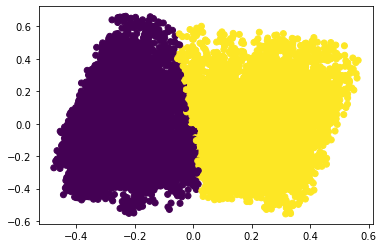

In [8]:
# Plotting the clusters
plt.scatter(X_mca.iloc[:, 0], X_mca.iloc[:, 1], c=labels, cmap='viridis')